# Project Milestone 2 Pipeline
* That you can handle the data in its size.
* That you understand what’s in the data (formats, distributions, missing values, correlations, etc.).
* That you considered ways to enrich, filter, transform the data according to your needs.
* That you have a reasonable plan and ideas for methods you’re going to use, giving their essential mathematical details in the notebook.
* That your plan for analysis and communication is reasonable and sound, potentially discussing alternatives to your choices that you considered but dropped.

In [108]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [109]:
movie_cols = ["wiki_id", "freebase_id", "name", "release_date", "revenue", "runtime", "languages", "countries", "genres"]
movie_df = pd.read_csv(
    './rawdata/MovieSummaries/movie.metadata.tsv', 
    sep="\t", 
    names=movie_cols
)
#characters_df = pd.read_csv(
#    './MovieSummaries/character.metadata.tsv',
#    index_col=False, 
#    sep="\t", 
#    names=["wiki_id", "freebase_id", "X", "character_name", "actor_dob", "actor_gender", "actor_height", "actor_ethnicity", "actor_name", "actor_release_date_age"]
#)
#characters_df = characters_df.drop(columns="X")
name_df = pd.read_csv(
    './rawdata/MovieSummaries/name.clusters.txt', 
    sep="\t",
    names = ['character_name', "freebase_id"]
)

## Basic Data Cleaning

In [110]:
import re

movie_df = pd.read_csv(
    './rawdata/MovieSummaries/movie.metadata.tsv', 
    sep="\t", 
    names=movie_cols
)

# Parses the multi value structure of the dataset format into a sorted array of items
# Returns null values for empty lists as NaN (so all missing values we use are NaN)
def parse_multi_values(x): 
    if not x: 
        return []
    x = x.split(',')
    result = []
    for combo in x: 
        combo = combo.split(":")
        if len(combo) > 1: 
            combo[1] = re.sub("[^a-zA-Z0-9\s]+", "", combo[1])
            combo[1] = re.sub("^\s", "", combo[1])
            combo[1] = combo[1].strip()
            result.append(combo[1])
    if not result:
        return []
    return sorted(result)

# Parses the language column specifically by removing "Langauge" from each entry
def parse_language(languages):
    if not languages or type(languages) != list:
        return []
    return list(map(lambda l : l.replace("Language", "").strip(), languages))

# Parses the date format into an int representing only the year. Values with missing entries are given NaN.
def parse_date(x):
    if not x or x == np.nan:
        return np.NaN
    return str(x).split("-")[0]

# Parse multi value attributes into arrays
for attribute in ["languages", "countries", "genres"]:
    movie_df[attribute] = movie_df[attribute].apply(parse_multi_values)

# Remove the redundant word "Language" from language column
movie_df["languages"] = movie_df["languages"].apply(parse_language)

# Parse release-date to all use the year as an int (don't need increased granularity right now)
movie_df["release_date"] = movie_df["release_date"].apply(parse_date)

# Replace missing numeric values with zero and convert to int rather than float
for col in ["runtime", "revenue"]:
    movie_df[col] = movie_df[col].fillna(0)
    movie_df[col] = movie_df[col].astype(int)


## Analyzing missing values

{'revenue': 73340, 'runtime': 20507, 'languages': 13866, 'countries': 8154, 'genres': 2294}


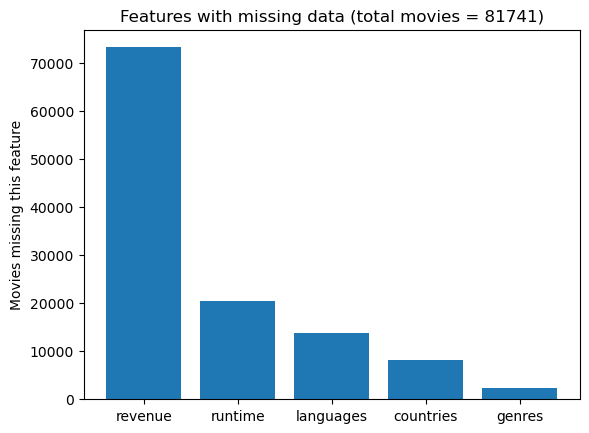

Rows without any missing data is 81741


In [111]:
# Let's check to what extent we have missing data
# For each column, count the number of missing data and plot a bar graph
def analyze_missing_values(df : pd.DataFrame): 
    # Dictionary from col to missing values count 
    missing = {}
    for col in df.columns:
        # Missing are na or empty falsy values such as empty lists
        num_missing = df[col].isna().sum() + (df[col].astype(bool) == False).sum()
        if num_missing > 0:
            missing[col] = num_missing
    print(missing)
    plt.bar(list(missing.keys()), list(missing.values()))
    plt.title("Features with missing data (total movies = " + str(df.shape[0]) + ")")
    plt.ylabel("Movies missing this feature")
    plt.show()

    # Count how many rows are without any missing values
    non_missing = (df.notnull().all(axis="columns") == True).sum()
    print("Rows without any missing data is", non_missing)

analyze_missing_values(movie_df)

## Basic data analysis 

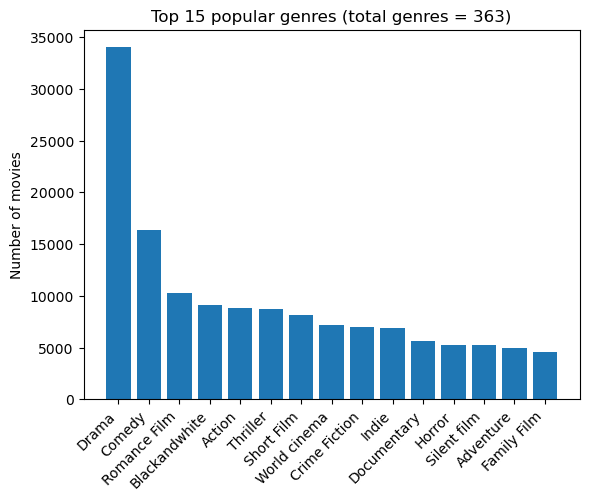

118 of movies have genre's that only occurr 20 times in the dataset


In [112]:
# Let's plot the popularity of genres over time 
# Y-axis being number of movies and genres 

# Function that maps a list of items in a series 
def to_1D(series):
    return pd.Series([x for _list in series for x in _list])

# Let's plot the top genres
genres = to_1D(movie_df["genres"]).value_counts()
top_k = 15
top_genres = genres.head(n=top_k)
plt.bar(top_genres.index, top_genres.values)
plt.title(f"Top {top_k} popular genres (total genres = {len(genres)})")
plt.ylabel("Number of movies")
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
)
plt.show()

obscure_threshold = 20
obscure_genres = genres[genres <= obscure_threshold]
print(f"{len(obscure_genres)} of movies have genre's that only occurr {obscure_threshold} times in the dataset")


## Cleaning up "release_date"

In [113]:

movie_count = movie_df.groupby("release_date").count()["wiki_id"]
movie_count = movie_count.dropna()
movie_count = movie_count.sort_values()[1:-1]
movie_count.describe()


count     129.000000
mean      580.139535
std       533.896083
min         1.000000
25%       272.000000
50%       518.000000
75%       687.000000
max      2465.000000
Name: wiki_id, dtype: float64

## how many films are released per year? 
#### ❌ one data made at year 1010 

release_date
2003    1662
2011    1824
2004    1872
2010    2022
2005    2102
2009    2247
2007    2389
2006    2434
2008    2465
nan     6902
Name: name, dtype: int64

year Index(['2005', '2006', '2007', '2008', '2009', '2010', 'nan'], dtype='object', name='release_date') has released more than 2000 movies


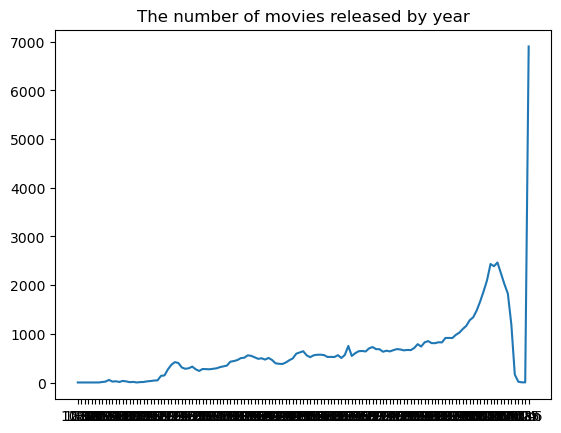

In [114]:
## Look at the number of film released per year
movie_df['release_date']
number_by_year = movie_df.groupby('release_date')['name'].count()
display(number_by_year.sort_values().tail(10))
years = list(range(1888, 2015, 1))
fig, ax = plt.subplots()
ax.plot(number_by_year.index, number_by_year.values )
plt.title("The number of movies released by year")
print(f"year {number_by_year[number_by_year.values > 2000].index} has released more than 2000 movies" )

## film ['action', 'adventure', 'actionadventure']
## film ['romantic', 'comedy]
## film ['romantic', 'comedy, action]


## top 10 genre 
# action
# adventure 

## Trying to do the genre analysis a little more 
* merge genre into broader categories 
* observe the number of film released per year over time 
* decide on the bucket to group 

In [115]:
# separate a word like "pyschological thriller" to "psychological" and "thriller"
def combine_lists(elements):
    result = []
    for x in elements: 
        result += x
    return result
movie_df['genre_divided'] = movie_df['genres'].apply(lambda x: [word.lower().split(" ") for word in x]).apply(combine_lists)

In [116]:
## drop all the rows where release_date = 'nan'
display("before dropping", movie_df.shape)
movie_df = movie_df[movie_df['release_date'] != 'nan']
display("after dropping", movie_df.shape)

## remove certain meaningless keywords from "genre", like "film", "movies"
## remove repeated words by changing to set; 
# if a film is ["romatic comedy", "dark comedy"], it would become ["romatic", "dark", "comedy"]
no_meaning_words = {"film", "movies", "of", "movie"}
def remove_certain_genre(l):
    l = set(l)
    for word in no_meaning_words:
        if word in l: 
            l.remove(word)
    return list(l)
movie_df['genre_divided'] = movie_df['genre_divided'].apply(remove_certain_genre)
display(movie_df[['release_date', 'genre_divided']].head(30)) 

## unfinished
## would be nice to combine "romatic" with "romance"
def combine_certain_genre(l):
    l = set(l)
    for word in no_meaning_words:
        if word in l: 
            l.remove(word)
    return list(l)

display(to_1D(movie_df['genre_divided']).value_counts().head(30))

'before dropping'

(81741, 10)

'after dropping'

(74839, 10)

,release_date,genre_divided
0,2001,"[action, horror, supernatural, adventure, thri..."
1,2000,"[crime, biographical, drama, mystery]"
2,1988,"[crime, fiction, drama]"
3,1987,"[thriller, erotic, psychological]"
4,1983,[drama]
5,1913,"[silent, comedy, blackandwhite, indie, short]"
6,2002,"[world, adventure, cinema, family, fantasy]"
7,1938,"[comedy, musical, blackandwhite]"
8,1974,"[comedy, musical, drama]"
9,1960,"[horror, supernatural]"


drama              32669
comedy             19889
fiction            10174
romance             9770
thriller            8879
blackandwhite       8817
action              8309
crime               7781
cinema              7584
short               7208
world               7174
indie               6779
romantic            5441
silent              5056
horror              5008
documentary         4998
adventure           4921
family              4877
actionadventure     4557
musical             4110
animation           3076
mystery             3056
science             2924
fantasy             2861
war                 2543
western             2234
japanese            2087
period              1745
piece               1743
comedydrama         1679
dtype: int64